Chapter 12

# 主成分分析
《线性代数》 | 鸢尾花书：数学不难

这段代码系统地演示了主成分分析（PCA）在多维时间序列数据上的完整流程。以下从数学角度对整个过程逐步进行解释，并嵌入必要公式。

---

$【数据加载与可视化】$

首先，从 pickle 文件中加载数据 $X_{df}$，这是一个形状为 $n \times p$ 的数据矩阵，其中 $n$ 是样本数量，$p$ 是特征数量。原始数据通过子图（subplots）可视化，用统一的 $y$ 轴范围比较各列数据走势，接着用成对特征散点图（PairPlot）查看特征之间的关系。

---

$【中心化（去均值）】$

对数据进行中心化处理：

$$
X_c = X - \mu
$$

其中 $\mu$ 是每列（特征）的均值，$X_c$ 是中心化后的数据。这一步是为了使得每一维特征的均值为 $0$，便于后续分析。

---

$【协方差矩阵】$

计算中心化数据的协方差矩阵：

$$
\Sigma = \frac{1}{n-1} X_c^\top X_c
$$

这是一个 $p \times p$ 对称矩阵，每个元素 $\Sigma_{ij}$ 表示第 $i$ 和第 $j$ 个特征之间的协方差。

---

$【标准差与标准化】$

协方差矩阵对角线上的元素为各特征的方差，取平方根后得到标准差向量 $\mathbf{d}$。再构造对角矩阵 $D = \text{diag}(\mathbf{d})$。

标准化操作如下：

$$
Z = X_c D^{-1}
$$

标准化后的数据 $Z$ 是无量纲的，其协方差矩阵即为相关性系数矩阵（correlation matrix）：

$$
P = \frac{1}{n-1} Z^\top Z
$$

这一步确保了每列的方差为 $1$，消除了单位和尺度的影响。

---

$【特征值分解（谱分解）】$

对相关性矩阵 $P$ 进行特征值分解：

$$
P = V \Lambda V^\top
$$

其中，$V$ 是特征向量矩阵，$\Lambda$ 是对角线为特征值的矩阵。按特征值从大到小排序，最大特征值所对应的特征向量代表最主要的方向。

热图可视化了谱分解的三部分：

$$
P = V \Lambda V^\top
$$

---

$【主成分投影】$

将标准化后的数据 $Z$ 投影到特征向量构成的新坐标系中：

$$
Y = Z V
$$

这里 $Y$ 是主成分得分矩阵，其列为各主成分的线性组合，行仍为每个样本的表示。

---

$【方差解释与陡坡图】$

各特征值表示每个主成分所解释的方差：

$$
\text{explained variance ratio} = \frac{\lambda_i}{\sum_j \lambda_j}
$$

画出每个主成分的解释能力（陡坡图）以及累计解释比例曲线，用于确定选择前几个主成分保留大部分信息。

---

$【数据还原】$

选择前 $k$ 个主成分进行近似重建，构造加载矩阵：

$$
\text{loadings} = V_{[:, :k]}
$$

再将 $Y$ 的前 $k$ 列投影回原空间：

1. 还原标准化数据：

$$
Z_{\text{hat}} = Y_{[:, :k]} V_{[:, :k]}^\top
$$

2. 缩放与平移还原原数据：

$$
X_{\text{hat}} = Z_{\text{hat}} D + \mu^\top
$$

---

$【还原数据、原始数据对比】$

绘制原始数据 $X$、近似数据 $X_{\text{hat}}$ 和它们之间的误差，观察还原效果。同时画出 $X_{\text{hat}}$ 的 PairPlot，并绘制散点图对比每一维：

$$
\text{scatter}(X_{\text{hat}}^i, X^i)
$$

若近似还原效果好，则散点应靠近 $y = x$ 的红线。

## 初始化

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 加载数据

In [6]:
X_df = pd.read_pickle('X_df.pkl')

In [7]:
X_df

0.5 yr      1 yr      2 yr      5 yr      7 yr     10 yr  \
DATE                                                                     
2022-01-04  0.000000 -0.050000 -0.012821  0.000000  0.012903  0.018405   
2022-01-05  0.000000  0.078947  0.077922  0.043796  0.031847  0.030120   
2022-01-06  0.045455  0.097561  0.060241  0.027972  0.024691  0.011696   
2022-01-07  0.043478 -0.044444 -0.011364  0.020408  0.018072  0.017341   
2022-01-10  0.166667  0.069767  0.057471  0.020000  0.011834  0.011364   
...              ...       ...       ...       ...       ...       ...   
2022-12-23  0.002146  0.004310  0.016509  0.018470  0.015915  0.021798   
2022-12-27  0.019272  0.019313  0.002320  0.020725  0.026110  0.024000   
2022-12-28 -0.002101 -0.008421 -0.002315  0.007614  0.010178  0.010417   
2022-12-29 -0.004211  0.000000  0.006961 -0.007557 -0.015113 -0.012887   
2022-12-30  0.006342  0.004246  0.016129  0.012690  0.012788  0.013055   

               20 yr     30 yr  
DATE                            
2022-01-04  0.024390  0.029851  
2022-01-05  0.009524  0.009662  
2022-01-06  0.000000  0.000000  
2022-01-07  0.014151  0.009569  
2022-01-10  0.000000  0.000000  
...              ...       ...  
2022-12-23  0.020460  0.024129  
2022-12-27  0.027569  0.028796  
2022-12-28  0.007317  0.012723  
2022-12-29 -0.009685 -0.015075  
2022-12-30  0.012225  0.012755  

[248 rows x 8 columns]

In [8]:
len(X_df)

248

## 可视化数据

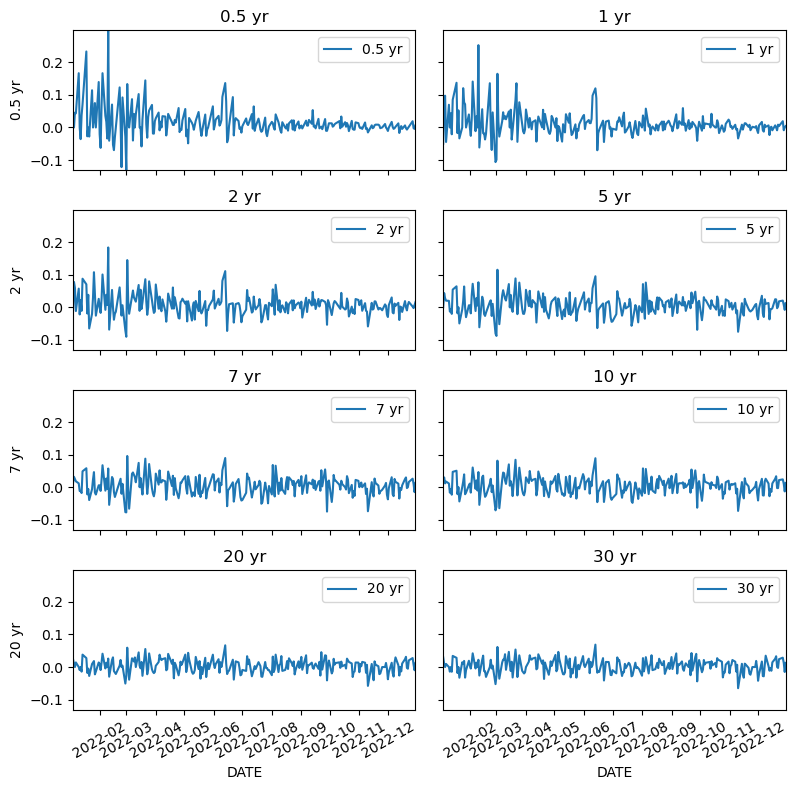

In [10]:
# 统一y轴范围：获取整个X_df的最小值和最大值
y_min = X_df.min().min()
y_max = X_df.max().max()

fig, axes = plt.subplots(4, 2, figsize=(8, 8), sharex = True, sharey = True)  # 可以根据需要调整figsize
axes = axes.flatten()  # 展平成一维，方便循环索引

# 遍历X_df的每一列
for i, col in enumerate(X_df.columns):
    sns.lineplot(data=X_df[col], 
                 markers=False, 
                 dashes=False, 
                 ax=axes[i])
    axes[i].set_title(col)  # 每张子图标题设置为列名
    axes[i].legend([col], loc='upper right', ncol=1)  # 设置图例
    axes[i].set_ylim(y_min, y_max)  # 设置统一y轴范围
    axes[i].set_xlim(X_df.index[0], X_df.index[-1]) 
    axes[i].tick_params(axis='x', rotation=30)  # 旋转标签避免重叠
# 调整子图布局，防止重叠
plt.tight_layout()

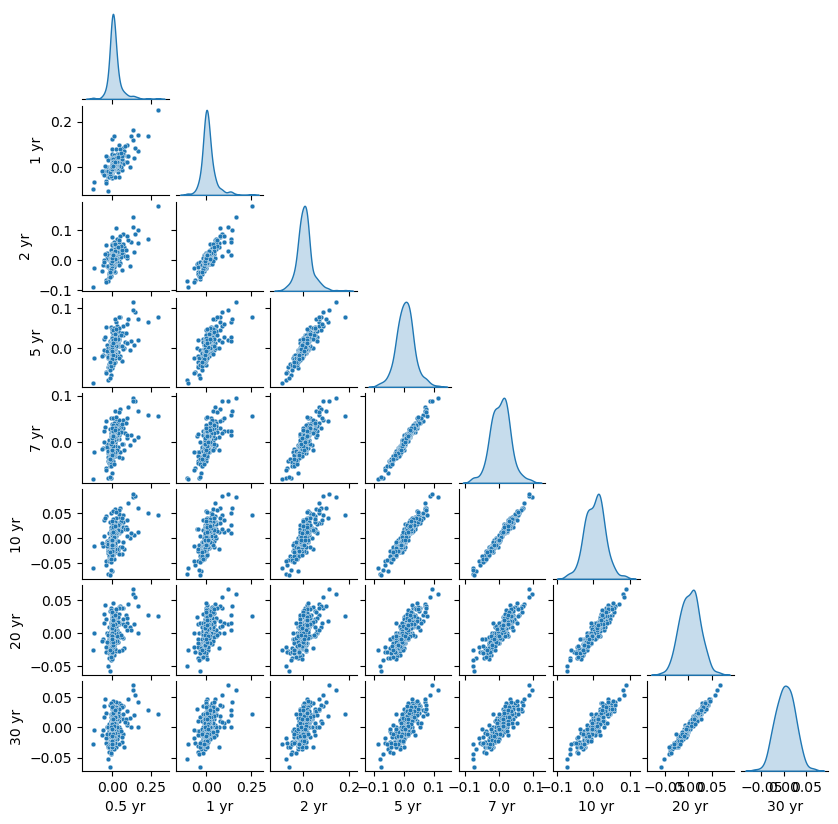

In [11]:
# 成对特征散点图
g = sns.pairplot(X_df, corner=True, diag_kind="kde", plot_kws={'s': 12})
# 设置图片大小（单位是英寸）
g.fig.set_size_inches(8, 8)

## 中心化

In [13]:
mean = X_df.mean()
mean = np.array(mean).reshape(-1,1)
mean

array([[0.01336972],
       [0.01074155],
       [0.00756404],
       [0.00477784],
       [0.00421179],
       [0.00387352],
       [0.00305352],
       [0.00297673]])

In [14]:
X_df_c = X_df - X_df.mean()

## 协方差矩阵

In [16]:
cov = X_df.cov()

<Axes: >

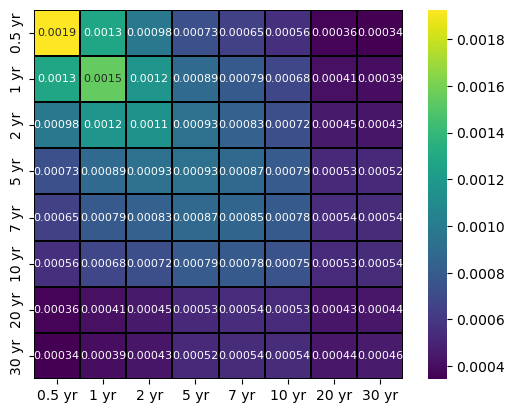

In [17]:
fig, ax = plt.subplots()
sns.heatmap(cov, ax = ax, 
            annot=True,
            annot_kws={"size": 8},
            linecolor='k', linewidths= '0.1',
            cmap = 'viridis', 
            square = True)

## 标准差

In [19]:
D_sq = np.sqrt(np.diag(cov))
D_sq

array([0.04388477, 0.03930359, 0.03382721, 0.03043679, 0.02918109,
       0.02732218, 0.02083015, 0.02144493])

In [20]:
D_sq_df = X_df.std()
D_sq_df

0.5 yr    0.043885
1 yr      0.039304
2 yr      0.033827
5 yr      0.030437
7 yr      0.029181
10 yr     0.027322
20 yr     0.020830
30 yr     0.021445
dtype: float64

(0.02, 0.045)

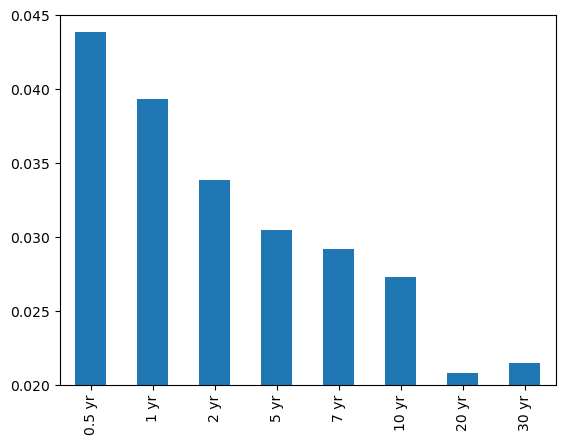

In [21]:
D_sq_df.plot(kind='bar')
plt.ylim(0.02, 0.045)

In [22]:
D = np.diag(D_sq)
D

array([[0.04388477, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.03930359, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.03382721, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.03043679, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.02918109,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02732218, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02083015, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.02144493]])

## 标准化

In [24]:
Z_df = (X_df - X_df.mean()) @ np.linalg.inv(D)
Z_df.columns = X_df.columns
Z_df

0.5 yr      1 yr      2 yr      5 yr      7 yr     10 yr  \
DATE                                                                     
2022-01-04 -0.304655 -1.545445 -0.602608 -0.156976  0.297845  0.531853   
2022-01-05 -0.304655  1.735359  2.079924  1.281928  0.947029  0.960647   
2022-01-06  0.731115  2.208944  1.557235  0.762044  0.701810  0.286302   
2022-01-07  0.686082 -1.404096 -0.559540  0.513534  0.474982  0.492915   
2022-01-10  3.493170  1.501794  1.475357  0.500124  0.261215  0.274141   
...              ...       ...       ...       ...       ...       ...   
2022-12-23 -0.255756 -0.163629  0.264444  0.449844  0.401059  0.656055   
2022-12-27  0.134494  0.218091 -0.155019  0.523956  0.750413  0.736635   
2022-12-28 -0.352527 -0.487554 -0.292039  0.093189  0.204459  0.239481   
2022-12-29 -0.400600 -0.273297 -0.017840 -0.405250 -0.662249 -0.613425   
2022-12-30 -0.160129 -0.165259  0.253198  0.259966  0.293887  0.336039   

               20 yr     30 yr  
DATE                            
2022-01-04  1.024319  1.253164  
2022-01-05  0.310621  0.311733  
2022-01-06 -0.146591 -0.138808  
2022-01-07  0.532758  0.307422  
2022-01-10 -0.146591 -0.138808  
...              ...       ...  
2022-12-23  0.835656  0.986338  
2022-12-27  1.176919  1.203971  
2022-12-28  0.204682  0.454462  
2022-12-29 -0.611553 -0.841789  
2022-12-30  0.440295  0.455976  

[248 rows x 8 columns]

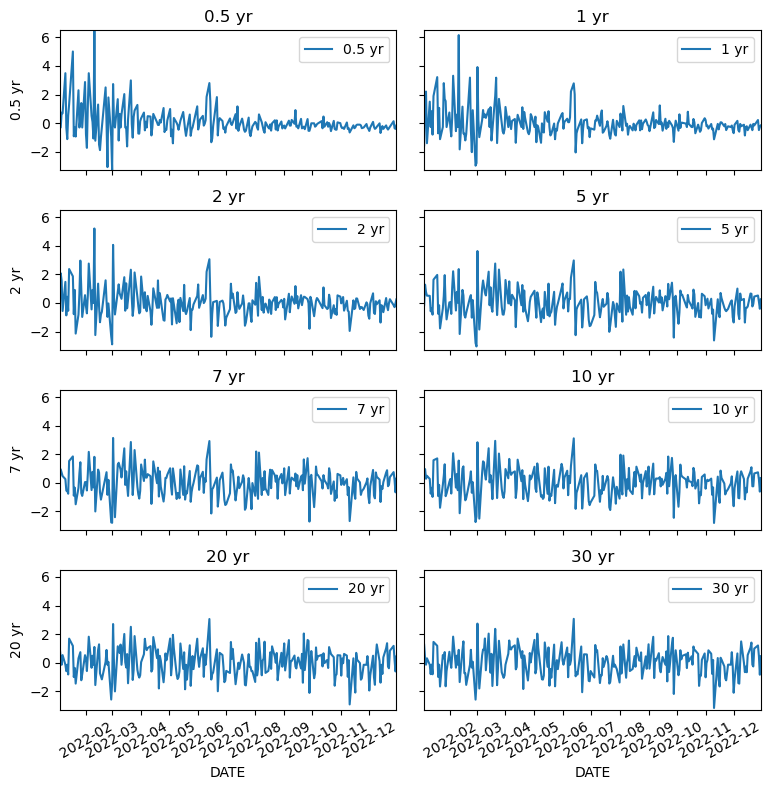

In [25]:
# 统一y轴范围：获取整个Z_df的最小值和最大值
y_min = Z_df.min().min()
y_max = Z_df.max().max()

fig, axes = plt.subplots(4, 2, figsize=(8, 8), sharex = True, sharey = True)  # 可以根据需要调整figsize
axes = axes.flatten()  # 展平成一维，方便循环索引

# 遍历X_df的每一列
for i, col in enumerate(Z_df.columns):
    sns.lineplot(data=Z_df[col], 
                 markers=False, 
                 dashes=False, 
                 ax=axes[i])
    axes[i].set_title(col)  # 每张子图标题设置为列名
    axes[i].legend([col], loc='upper right', ncol=1)  # 设置图例
    axes[i].set_ylim(y_min, y_max)  # 设置统一y轴范围
    axes[i].set_xlim(Z_df.index[0], Z_df.index[-1]) 
    axes[i].tick_params(axis='x', rotation=30)  # 旋转标签避免重叠
# 调整子图布局，防止重叠
plt.tight_layout()

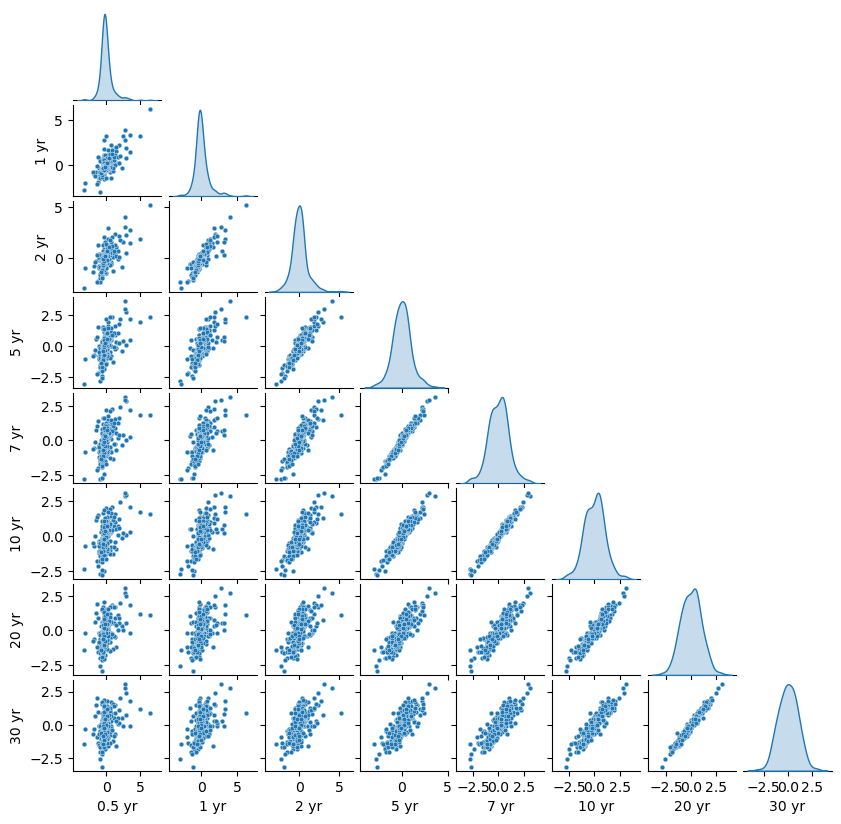

In [26]:
# 成对特征散点图
g = sns.pairplot(Z_df, corner=True, diag_kind="kde", plot_kws={'s': 12})
# 设置图片大小（单位是英寸）
g.fig.set_size_inches(8, 8)

## 相关性系数矩阵

In [28]:
P = X_df.corr()
P

0.5 yr      1 yr      2 yr      5 yr      7 yr     10 yr     20 yr  \
0.5 yr  1.000000  0.741326  0.658817  0.547214  0.508018  0.469002  0.395009   
1 yr    0.741326  1.000000  0.877098  0.741927  0.685748  0.633442  0.497752   
2 yr    0.658817  0.877098  1.000000  0.899742  0.838473  0.782254  0.637459   
5 yr    0.547214  0.741927  0.899742  1.000000  0.982671  0.951628  0.833816   
7 yr    0.508018  0.685748  0.838473  0.982671  1.000000  0.983504  0.894960   
10 yr   0.469002  0.633442  0.782254  0.951628  0.983504  1.000000  0.939536   
20 yr   0.395009  0.497752  0.637459  0.833816  0.894960  0.939536  1.000000   
30 yr   0.365413  0.466968  0.593849  0.793134  0.857845  0.915748  0.981736   

           30 yr  
0.5 yr  0.365413  
1 yr    0.466968  
2 yr    0.593849  
5 yr    0.793134  
7 yr    0.857845  
10 yr   0.915748  
20 yr   0.981736  
30 yr   1.000000

In [29]:
n = len(Z_df)
Z_df.T @ Z_df/(n-1)
# 检验

0.5 yr      1 yr      2 yr      5 yr      7 yr     10 yr     20 yr  \
0.5 yr  1.000000  0.741326  0.658817  0.547214  0.508018  0.469002  0.395009   
1 yr    0.741326  1.000000  0.877098  0.741927  0.685748  0.633442  0.497752   
2 yr    0.658817  0.877098  1.000000  0.899742  0.838473  0.782254  0.637459   
5 yr    0.547214  0.741927  0.899742  1.000000  0.982671  0.951628  0.833816   
7 yr    0.508018  0.685748  0.838473  0.982671  1.000000  0.983504  0.894960   
10 yr   0.469002  0.633442  0.782254  0.951628  0.983504  1.000000  0.939536   
20 yr   0.395009  0.497752  0.637459  0.833816  0.894960  0.939536  1.000000   
30 yr   0.365413  0.466968  0.593849  0.793134  0.857845  0.915748  0.981736   

           30 yr  
0.5 yr  0.365413  
1 yr    0.466968  
2 yr    0.593849  
5 yr    0.793134  
7 yr    0.857845  
10 yr   0.915748  
20 yr   0.981736  
30 yr   1.000000

<Axes: >

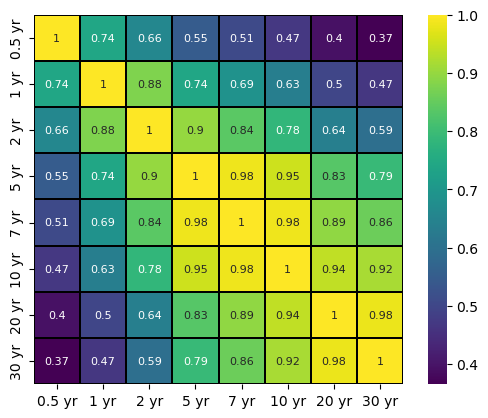

In [30]:
fig, ax = plt.subplots()
sns.heatmap(P, ax = ax, 
            annot=True,
            annot_kws={"size": 8},
            linecolor='k', linewidths= '0.1',
            cmap = 'viridis', 
            square = True)

## 特征值分解 (谱分解)

In [32]:
lambdas, V = np.linalg.eig(P)
# 按特征值从大到小排序的索引
idx = np.argsort(-lambdas)  # 注意是负号，表示降序排序

# 排列特征值
lambdas_sorted = lambdas[idx]

# 按相应顺序排列特征向量的列
V = V[:, idx]
Lambda = np.diag(lambdas_sorted)
# Lambda

<Axes: >

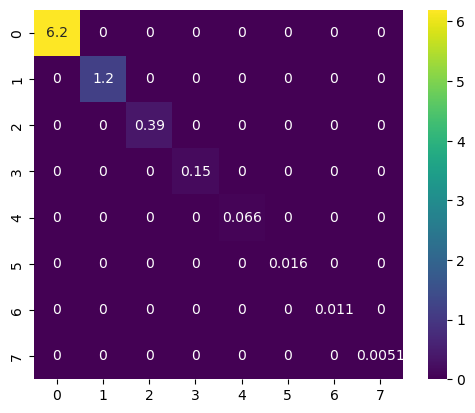

In [33]:
fig, ax = plt.subplots()
sns.heatmap(Lambda, ax = ax, 
            annot=True,
            cmap = 'viridis', 
            square = True)

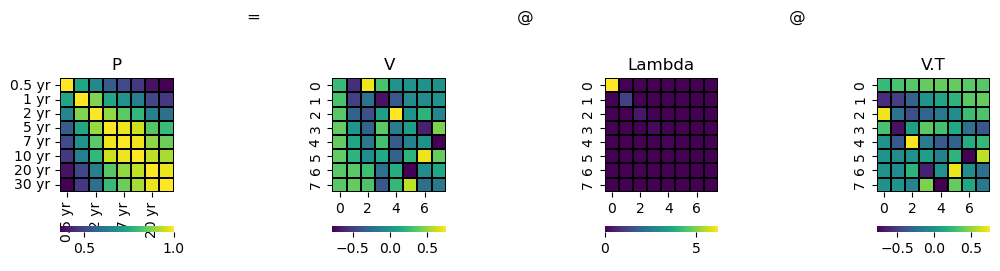

In [34]:
fig, axs = plt.subplots(1, 7, figsize=(12, 3))  # 创建子图

plt.sca(axs[0])
ax = sns.heatmap(P, cmap='viridis', 
                 # vmax=vmax, vmin=vmin, 
                 # vmax=8, vmin=-8,  # 绘制矩阵 X 的热图
                 # vmax=15, vmin=-15, 
                 linecolor = 'k',linewidths = 0.1,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.title('P')

plt.sca(axs[1])
plt.title('=')  # 绘制等号
plt.axis('off')


plt.sca(axs[2])
ax = sns.heatmap(V, cmap='viridis',
                 # vmax=vmax, vmin=vmin, 
                 linecolor = 'k',linewidths = 0.1,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.title('V')

plt.sca(axs[3])
plt.title('@')  # 绘制乘号
plt.axis('off')

plt.sca(axs[4])
ax = sns.heatmap(Lambda, cmap='viridis', 
                 # vmax=vmax, vmin=vmin, 
                 # vmax=15, vmin=-15, 
                 linecolor = 'k',linewidths = 0.1,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.title('Lambda')

plt.sca(axs[5])
plt.title('@')  # 绘制乘号
plt.axis('off')

plt.sca(axs[6])
ax = sns.heatmap(V.T, cmap='viridis', 
                 # vmax=vmax, vmin=vmin, 
                 linecolor = 'k',linewidths = 0.1,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.title('V.T')
plt.savefig('4.svg')

In [35]:
lambdas_sorted

array([6.19819963e+00, 1.16487298e+00, 3.86438666e-01, 1.53121560e-01,
       6.55072070e-02, 1.55648171e-02, 1.11641690e-02, 5.13097110e-03])

## 数据投影

In [37]:
Y = Z_df @ V
Y

0         1         2         3         4         5  \
DATE                                                                     
2022-01-04  0.280490  2.120133  0.992302  0.385408  0.341954  0.096475   
2022-01-05  2.680390 -0.701660 -1.762888 -0.434904  0.283365  0.085417   
2022-01-06  2.028260 -1.898829 -0.963545 -0.588416 -0.107884  0.007180   
2022-01-07  0.405207  0.949265  0.998969  1.325394 -0.128117 -0.063829   
2022-01-10  2.204342 -3.167920  1.330348  0.528633  0.283518  0.115428   
...              ...       ...       ...       ...       ...       ...   
2022-12-23  1.206798  1.039372  0.074929 -0.093634  0.243919  0.090624   
2022-12-27  1.672576  1.026079  0.531691 -0.280451 -0.249498 -0.061103   
2022-12-28  0.090713  0.857381  0.097397  0.131652 -0.053836  0.163691   
2022-12-29 -1.362823 -0.408686 -0.422330  0.063103  0.238182 -0.128840   
2022-12-30  0.660458  0.550843 -0.049176  0.061442  0.198630  0.003438   

                   6         7  
DATE                            
2022-01-04  0.111479 -0.121303  
2022-01-05  0.138817  0.080526  
2022-01-06 -0.017991 -0.169880  
2022-01-07 -0.116009  0.109808  
2022-01-10  0.168594  0.048109  
...              ...       ...  
2022-12-23 -0.002993  0.090335  
2022-12-27 -0.153695 -0.057867  
2022-12-28 -0.037097 -0.048182  
2022-12-29  0.033955  0.126681  
2022-12-30  0.017567 -0.010384  

[248 rows x 8 columns]

## 方差解释比例

In [39]:
variance_V = lambdas_sorted
variance_V
# 计算主成分的方差解释比例

array([6.19819963e+00, 1.16487298e+00, 3.86438666e-01, 1.53121560e-01,
       6.55072070e-02, 1.55648171e-02, 1.11641690e-02, 5.13097110e-03])

In [40]:
explained_var_ratio = variance_V / variance_V.sum()

In [41]:
PC_range = np.arange(len(variance_V)) + 1

In [42]:
labels = ['$PC_' + str(index) + '$' for index in PC_range]

(0.9, 8.1)

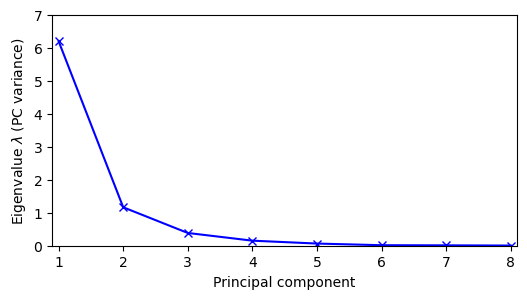

In [43]:
# 陡坡图
fig, ax = plt.subplots(figsize = (6,3))

ax.plot(PC_range, variance_V, 'b', marker = 'x')
ax.set_xlabel(r'Principal component')
ax.set_ylabel(r'Eigenvalue $\lambda$ (PC variance)')
ax.set_ylim(0,7); ax.set_xticks(PC_range)
ax.set_xlim(PC_range.min() - 0.1,PC_range.max() + 0.1)

Text(0.5, 0, 'Principal component')

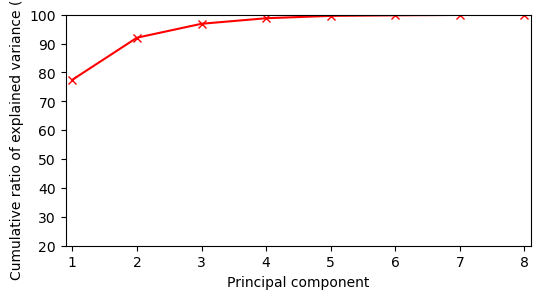

In [44]:
# 陡坡图
fig, ax = plt.subplots(figsize = (6,3))
ax.plot(PC_range, np.cumsum(explained_var_ratio)*100, 
         'r', marker = 'x')
ax.set_ylabel('Cumulative ratio of explained variance (%)')
ax.set_ylim(20,100)
ax.set_xlim(PC_range.min() - 0.1,PC_range.max() + 0.1)
ax.set_xlabel('Principal component')

## 还原原始数据

In [46]:
# 主元数量
num_p = 1 # 2, 3

In [47]:
loadings= V[:,0:num_p]

In [48]:
# 近似还原Z
Z_df_hat = Y.iloc[:,:num_p] @ loadings.T

In [49]:
# Z_df @ loadings @ loadings.T

In [50]:
# 近似还原X
X_df_hat = Z_df_hat @ D + mean.T # 先缩放，再平移

In [51]:
X_df_hat.columns = X_df.columns
X_df_hat

0.5 yr      1 yr      2 yr      5 yr      7 yr     10 yr  \
DATE                                                                     
2022-01-04  0.016529  0.014238  0.010967  0.008106  0.007412  0.006842   
2022-01-05  0.043557  0.044156  0.040084  0.036585  0.034795  0.032239   
2022-01-06  0.036213  0.036027  0.032172  0.028846  0.027354  0.025338   
2022-01-07  0.017933  0.015793  0.012480  0.009586  0.008835  0.008162   
2022-01-10  0.038196  0.038222  0.034309  0.030936  0.029363  0.027201   
...              ...       ...       ...       ...       ...       ...   
2022-12-23  0.026961  0.025786  0.022206  0.019098  0.017981  0.016645   
2022-12-27  0.032207  0.031593  0.027857  0.024625  0.023296  0.021574   
2022-12-28  0.014391  0.011872  0.008665  0.005854  0.005247  0.004833   
2022-12-29 -0.001979 -0.006248 -0.008971 -0.011394 -0.011338 -0.010549   
2022-12-30  0.020808  0.018975  0.015577  0.012615  0.011747  0.010863   

               20 yr     30 yr  
DATE                            
2022-01-04  0.005153  0.005068  
2022-01-05  0.023118  0.022958  
2022-01-06  0.018237  0.018097  
2022-01-07  0.006087  0.005997  
2022-01-10  0.019555  0.019410  
...              ...       ...  
2022-12-23  0.012087  0.011973  
2022-12-27  0.015574  0.015445  
2022-12-28  0.003733  0.003653  
2022-12-29 -0.007148 -0.007183  
2022-12-30  0.007998  0.007900  

[248 rows x 8 columns]

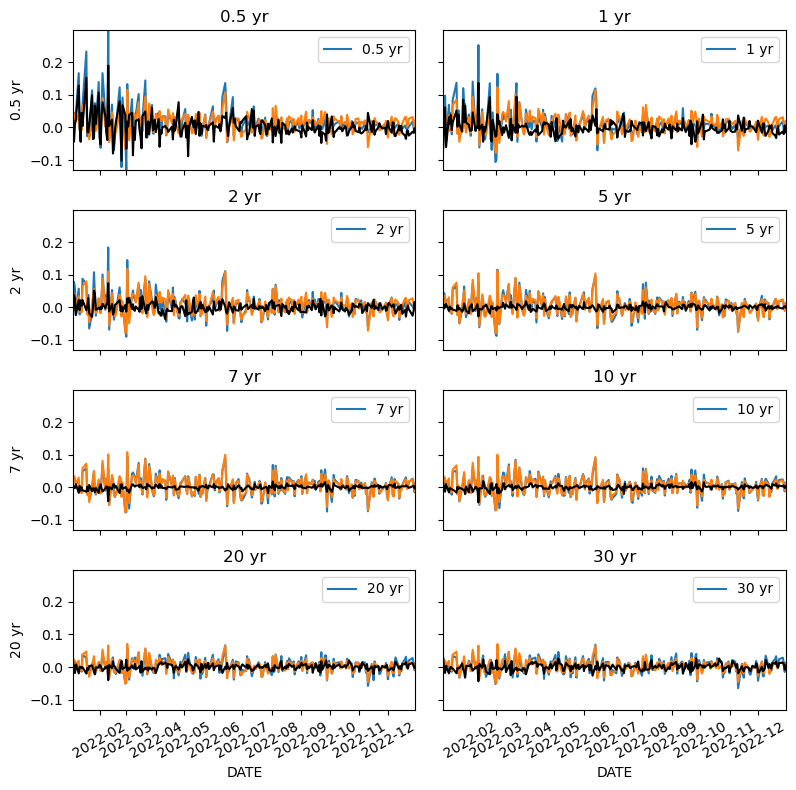

In [52]:
# 比较原始数据和还原数据

# 统一y轴范围：获取整个X_df_hat的最小值和最大值
y_min = X_df.min().min()
y_max = X_df.max().max()

fig, axes = plt.subplots(4, 2, figsize=(8, 8), sharex = True, sharey = True)  # 可以根据需要调整figsize
axes = axes.flatten()  # 展平成一维，方便循环索引

# 遍历X_df的每一列
for i, col in enumerate(X_df.columns):
    # 原数据
    sns.lineplot(data=X_df[col], 
                 markers=False, 
                 dashes=False, 
                 ax=axes[i])
    # 近似数据
    sns.lineplot(data=X_df_hat[col], 
                 markers=False, 
                 dashes=False, 
                 ax=axes[i])
    # 误差
    sns.lineplot(X_df[col] - X_df_hat[col], 
                 c = 'k', ax = axes[i]) 

    axes[i].set_title(col)  # 每张子图标题设置为列名
    axes[i].legend([col], loc='upper right', ncol=1)  # 设置图例
    axes[i].set_ylim(y_min, y_max)  # 设置统一y轴范围
    axes[i].set_xlim(X_df_hat.index[0], X_df_hat.index[-1]) 
    axes[i].tick_params(axis='x', rotation=30)  # 旋转标签避免重叠
# 调整子图布局，防止重叠
plt.tight_layout()

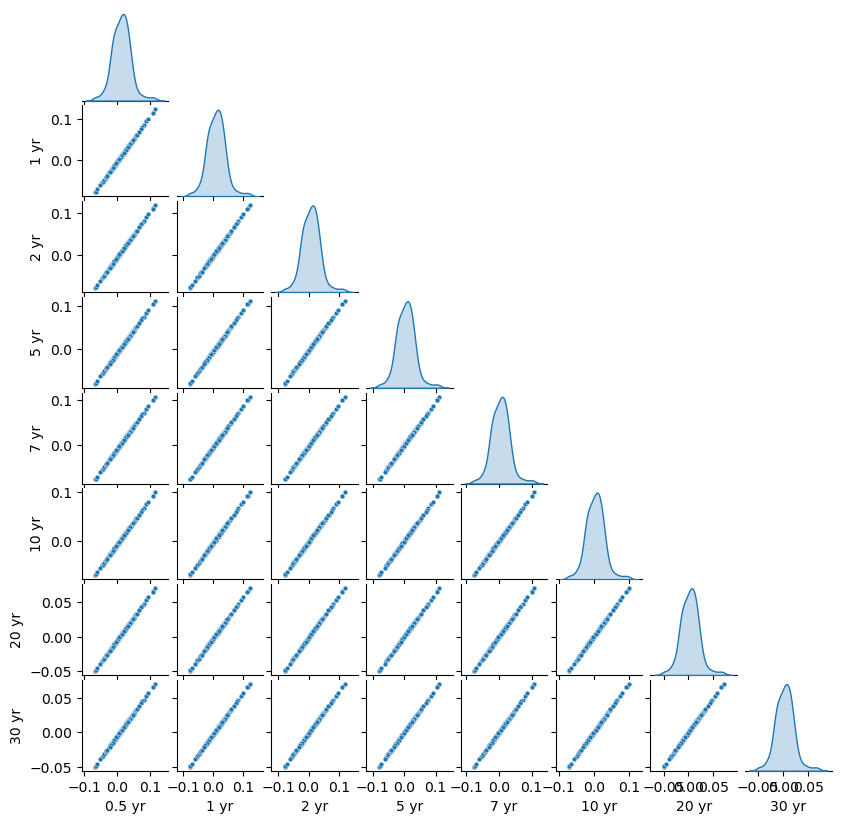

In [53]:
# 成对特征散点图
g = sns.pairplot(X_df_hat, corner=True, diag_kind="kde", plot_kws={'s': 12})
# 设置图片大小（单位是英寸）
g.fig.set_size_inches(8, 8)

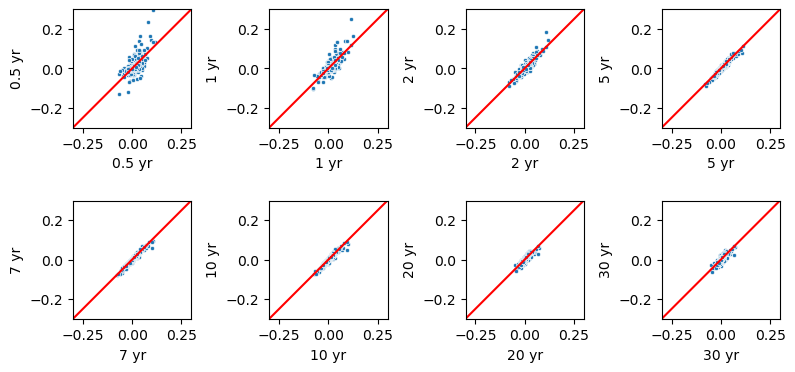

In [54]:
# 散点图
fig, axes = plt.subplots(2,4,figsize=(8,4))
axes = axes.flatten()

for col_idx, ax_idx in zip(list(X_df_hat.columns),axes):
    sns.scatterplot(x = X_df_hat[col_idx],
                    y = X_df[col_idx], 
                    marker = '.',
                    ax = ax_idx)
    ax_idx.plot([-0.3, 0.3],[-0.3, 0.3],c = 'r')
    ax_idx.set_aspect('equal', adjustable='box')
    ax_idx.set_xlim(-0.3, 0.3); ax_idx.set_ylim(-0.3, 0.3)

plt.tight_layout()

作者	**生姜DrGinger**  
脚本	**生姜DrGinger**  
视频	**崔崔CuiCui**  
开源资源	[**GitHub**](https://github.com/Visualize-ML)  
平台	[**油管**](https://www.youtube.com/@DrGinger_Jiang)		
		[**iris小课堂**](https://space.bilibili.com/3546865719052873)		
		[**生姜DrGinger**](https://space.bilibili.com/513194466)  